In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tf.compat.v1.enable_eager_execution(
    config=None,
    device_policy=None,
    execution_mode=None
)

In [ ]:
!unzip -q miml-image-data.zip
!rm -rf miml-image-data.zip
!unzip original.zip

Archive:  original.zip
   creating: original/
  inflating: original/103.jpg        
  inflating: original/104.jpg        
  inflating: original/105.jpg        
  inflating: original/106.jpg        
  inflating: original/107.jpg        
  inflating: original/109.jpg        
  inflating: original/11.jpg         
  inflating: original/110.jpg        
  inflating: original/112.jpg        
  inflating: original/117.jpg        
  inflating: original/119.jpg        
  inflating: original/12.jpg         
  inflating: original/120.jpg        
  inflating: original/121.jpg        
  inflating: original/122.jpg        
  inflating: original/123.jpg        
  inflating: original/124.jpg        
  inflating: original/125.jpg        
  inflating: original/126.jpg        
  inflating: original/128.jpg        
  inflating: original/131.jpg        
  inflating: original/133.jpg        
  inflating: original/135.jpg        
  inflating: original/137.jpg        
  inflating: original/138.jpg        
  in

In [ ]:
df = pd.DataFrame([file for file in os.listdir('original')], columns=['ImageId'])

y_json = pd.read_json('labels.json', lines=True)
y_label_vec = [np.asarray((row==1)*1) for index, row in y_json.iterrows()]

df['Labels_vec'] = df['ImageId'].map(lambda x: y_label_vec[int(str.split(x, '.')[0])-1].tolist())

label_names = ['desert', 'mountains', 'sea', 'sunset', 'trees']
df['Labels'] = df['Labels_vec'].map(lambda x: [label_names[i] for i, j in enumerate(x) if j==1])
df['Classnum'] = df['Labels'].map(lambda x: len(x))
df.head()

,ImageId,Labels_vec,Labels,Classnum
0,435.jpg,"[0, 1, 0, 0, 0]",[mountains],1
1,153.jpg,"[1, 0, 0, 0, 0]",[desert],1
2,827.jpg,"[0, 0, 1, 0, 0]",[sea],1
3,1544.jpg,"[0, 0, 0, 1, 0]",[sunset],1
4,484.jpg,"[0, 1, 0, 0, 0]",[mountains],1


{'desert': 409, 'mountains': 458, 'sea': 580, 'sunset': 465, 'trees': 560}


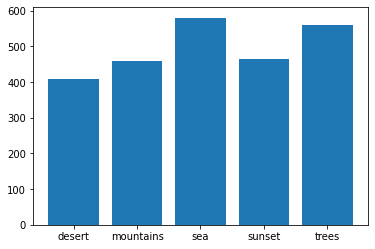

1    1543
2     442
3      15
Name: Classnum, dtype: int64


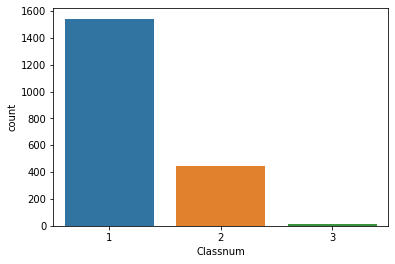

In [ ]:
class_summary = np.asarray(y_label_vec).sum(axis=0).tolist()
class_count_dict = {label_names[i]: class_summary[i] for i in range(len(class_summary))}
print(class_count_dict)

xs = np.arange(len(label_names)) 
plt.bar(xs, class_summary)
plt.xticks(xs, label_names)
plt.show()

print(df['Classnum'].value_counts())
sns.countplot(df['Classnum'])

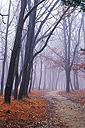

1958.jpg ['trees']


In [ ]:
id = 13

from IPython.display import display

img = Image.open('original/'+df.loc[id, 'ImageId'])
display(img)
print(df.loc[id, 'ImageId'], df.loc[id, 'Labels'])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=7, stratify=df['Classnum'])
print(train_df.shape, test_df.shape)

(1600, 4) (400, 4)


In [ ]:
image_height = 224
image_width = 224

bs = 64
SEED = 7

train_aug_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, brightness_range=(0.9, 1.1), zoom_range=0.1, horizontal_flip=True, 
                               preprocessing_function=preprocess_input)

test_aug_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug_gen.flow_from_dataframe(train_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=bs, seed=SEED)
test_gen = test_aug_gen.flow_from_dataframe(test_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=bs, shuffle=False)



Found 1600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


In [ ]:

model = models.Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=5, activation='sigmoid'))
model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10035300  
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.5214 - binary_accuracy: 0.7738
Epoch 00001: val_binary_accuracy improved from -inf to 0.90833, saving model to best_model.h5
25/25 [==============================] - 25s 1s/step - loss: 0.5214 - binary_accuracy: 0.7738 - val_loss: 0.2485 - val_binary_accuracy: 0.9083
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.2975 - binary_accuracy: 0.8779
Epoch 00002: val_binary_accuracy improved from 0.90833 to 0.91875, saving model to best_model.h5
25/25 [==============================] - 24s 969ms/step - loss: 0.2975 - binary_accuracy: 0.8779 - val_loss: 0.2025 - val_binary_accuracy: 0.9187
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.2540 - binary_accuracy: 0.8981
Epoch 00003: val_binary_accuracy improved from 0.91875 to 0.92917, saving model to best_model.h5
25/25 [==============================] - 24s 975ms/step - loss: 0.2540 - binary_accuracy: 0.8981 - val_loss: 0.1782 - va

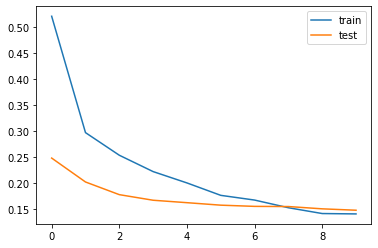

In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)

EPOCH_NUM = 10

history = model.fit_generator(train_gen, steps_per_epoch=train_df.shape[0]//bs, epochs=EPOCH_NUM, callbacks=[mc], 
                              validation_data=test_gen, validation_steps=test_df.shape[0]//bs)

saved_model = models.load_model('best_model.h5')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

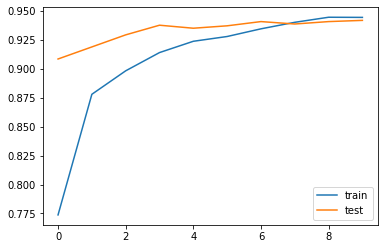

In [ ]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
_, y_test = next(test_gen)
y_test_n = pd.Series([y_test[i].astype('int') for i in range(y_test.shape[0])])
print([(y_test_n[i] == test_df['Labels_vec'][:64].reset_index(drop=True)[i]).all() for i in range(y_test.shape[0])])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [ ]:
y_test_pred = saved_model.predict(test_gen, steps=(test_df.shape[0]//bs)+1)
test_df['Labels_vec_pred'] = [y_test_pred[i] for i in range(y_test_pred.shape[0])]
test_df = test_df.reset_index(drop=True)
test_df['Labels_pred'] = test_df['Labels_vec_pred'].map(lambda x: [label_names[i] for i, j in enumerate(x) if j > 0.5])
test_df['BCE_Loss'] = [binary_crossentropy(test_df.loc[i, 'Labels_vec'], test_df.loc[i, 'Labels_vec_pred']).numpy() for i in range(test_df.shape[0])]

test_df_r = test_df.sort_values(by='BCE_Loss', ascending=False).reset_index(drop=True)
test_df_r.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ImageId,Labels_vec,Labels,Classnum,Labels_vec_pred,Labels_pred,BCE_Loss
0,32.jpg,"[1, 0, 0, 0, 1]","[desert, trees]",2,"[0.045670945, 0.0018927446, 0.00018348673, 0.9...",[sunset],2.160332
1,387.jpg,"[1, 0, 0, 0, 0]",[desert],1,"[0.4257862, 0.0014994921, 0.00022307281, 0.998...","[sunset, trees]",1.746278
2,1327.jpg,"[0, 1, 0, 1, 0]","[mountains, sunset]",2,"[6.267194e-05, 0.02621667, 0.9626701, 0.741438...","[sea, sunset]",1.452399
3,481.jpg,"[0, 1, 0, 0, 0]",[mountains],1,"[0.011364001, 0.0352494, 0.04206912, 0.1881111...",[trees],1.356363
4,1934.jpg,"[0, 1, 0, 0, 1]","[mountains, trees]",2,"[0.016071793, 0.0065193544, 0.5886663, 0.00823...","[sea, trees]",1.316088


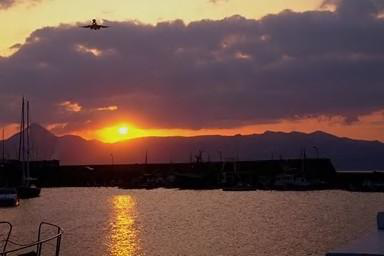

1329.jpg ['sea', 'sunset'] ['sunset']


In [ ]:
id = 89
img = Image.open('original/'+test_df_r.loc[id, 'ImageId'])
display(img)
print(test_df_r.loc[id, 'ImageId'], test_df_r.loc[id, 'Labels'], test_df_r.loc[id, 'Labels_pred'])